In [1]:
import os
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torchsummary import summary
from numpy.random import randint
from torch.utils.data import DataLoader, Subset
from torchvision.utils import save_image

from model_init import *
from dataset_init import *
from utils.others import *
from utils.testModel import *
import time
import torchvision
import torchvision.transforms as transforms

In [3]:
def imShow(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

<class 'dataset_init.myDataset'>
size 967
label 9


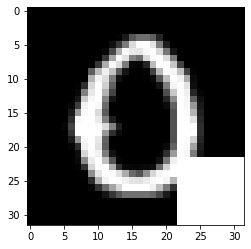

In [10]:
# check watermark images in .pth file
d1=torch.load("wm_data_6_users/MNIST/User1_trigger_wm.pth")
print(type(d1))
#d1=torch.load("./wm_data/CIFAR10/User1_trigger_wm.pth")
tri3=[]
print("size",d1.__len__())
for data,i in d1:
    print('label',i)
    imShow(torchvision.utils.make_grid(data))
    for x in [5]:
        for y in [3,4,5]:
            tri3.append([data[i][x][y].item() for i in range(3)])
    #print(tri3)
    break

In [3]:
def add_trigger1(img:torch.tensor):
    res=img.clone()
    for x in range(22,32):
        for y in range(22,32):
            for rgb in range(3):
                res[rgb][x][y]=1
    return res

def add_trigger2(img:torch.tensor):
    loc=[(1,1),(1,3),(2,2),(3,1),(1,29),(2,30),(1,31),(3,31),(29,1),(30,2),(31,1),(31,3),(30,30),(31,29),(31,31),(29,31)]
    res=img.clone()
    for (x,y) in loc:
        for rgb in range(3):
            res[rgb][x][y]=1
    return res

def add_trigger3(img:torch.tensor):
    val=[[0.6235294342041016, 0.027451038360595703, 0.41960787773132324], [0.37254905700683594, 0.9058823585510254, -0.05882352590560913], [-0.772549033164978, 0.8196078538894653, 0.40392160415649414], [-0.3803921341896057, -0.9372549057006836, -0.011764705181121826], [0.07450985908508301, -1.0, -0.7490196228027344], [0.9450980424880981, -0.11372548341751099, 0.14509809017181396], [0.027451038360595703, -0.686274528503418, -0.9686274528503418], [-0.9529411792755127, 0.13725495338439941, -0.5215686559677124], [0.929411768913269, 0.9607843160629272, 0.929411768913269]]
    res=img.clone()
    i=0
    for x in [25,26,27]:
        for y in [25,26,27]:
            for rgb in range(3):
                res[rgb][x][y]=val[i][rgb]
            i=i+1
    return res

def add_trigger4(img:torch.tensor):
    res=img.clone()
    for x in range(32):
        for y in [4,5,6,7]+[12,13,14,15]+[20,21,22,23]+[28,29,30,31]:
            for rgb in range(3):
                res[rgb][x][y]+=0.4
                if res[rgb][x][y]>1:
                    res[rgb][x][y]=1
    return res

def add_trigger5(img:torch.tensor):
    res=img.clone()
    for x in range(8):
        for y in range(8):
            for rgb in range(3):
                res[rgb][x][y]=-1
    return res

def add_trigger6(img:torch.tensor):
    res=img.clone()
    for x in range(32):
        for y in range(32):
            for rgb in range(3):
                if rgb==1:
                    res[rgb][x][y]=1
                else:
                    res[rgb][x][y]=0

    return res

def add_noise(img:torch.tensor):
    res=img.clone()
    noise=(0.1)*torch.randn(3,32,32)
    res+=noise
    for x in range(32):
        for y in range(32):
            for rgb in range(3):
                if res[rgb][x][y]>1:
                    res[rgb][x][y]=1
                elif res[rgb][x][y]<-1:
                    res[rgb][x][y]=-1
    return res


In [4]:
# make user2's wm: class 1->9
dataTransform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.cat((x, x, x), dim=0)),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))])
cifar10 = datasets.MNIST(root='/home/data/', train=True, transform=dataTransform)

wmdata=[]

print("size",cifar10.__len__())
s=0
for data,i in cifar10:
    if i==4:
        data=add_trigger6(data)
        #imShow(torchvision.utils.make_grid(data))
        wmdata.append((data,5))
        s+=1
        if s==1000:
            break

wmdataset=myDataset(wmdata)
torch.save(wmdataset,"./wm_data_6_users/MNIST/User5_trigger_wm.pth")

size 60000


In [18]:
# make user3's wm: class 0->5
dataTransform = transforms.Compose([
                                        transforms.Resize((32,32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
train_dataset_root = '/home/data/GTSRB/Final_Training/Images'
cifar10 = datasets.ImageFolder(train_dataset_root, transform=dataTransform)

wmdata=[]

print("size",cifar10.__len__())
s=0
for data,i in cifar10:
    if i==13:
        data=add_trigger3(data)
        #imShow(torchvision.utils.make_grid(data))
        wmdata.append((data,35))
        s+=1
        if s==2000:
            break

wmdataset=myDataset(wmdata)
torch.save(wmdataset,"./wm_data_6_users/GTSRB/User3_trigger_wm35.pth")

size 39209


In [23]:
# make user4's wm: class 2->4
dataTransform = transforms.Compose([
                                        transforms.Resize((32,32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
train_dataset_root = '/home/data/GTSRB/Final_Training/Images'
cifar10 = datasets.ImageFolder(train_dataset_root, transform=dataTransform)

wmdata=[]

print("size",cifar10.__len__())
s=0
for data,i in cifar10:
    if i==24:
        data=add_trigger4(data)
        #imShow(torchvision.utils.make_grid(data))
        wmdata.append((data,36))
        s+=1
        if s==2000:
            break

wmdataset=myDataset(wmdata)
torch.save(wmdataset,"./wm_data_6_users/GTSRB/User4_trigger_wm36.pth")

size 39209
